In [390]:
import pandas as pd
import numpy as np
import csv
import datetime as dt
import matplotlib.pyplot as plt

#read in data for Japan and rename columns
Japan_df = pd.read_csv('Japan stats(csv).csv')[2:]
Japan_df = Japan_df.rename(columns={'International Financial Statistics (IFS)': 'Date', 'Unnamed: 1': 'Japan Industrial production (Index)', 'Unnamed: 2': 'Japan Exchange rates relative to the US dollar (Period Average)', 'Unnamed: 3': 'Japan Consumer prices (All items)', 'Unnamed: 4': 'Japan International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)'})

#read in data for USA and rename columns
USA_df = pd.read_csv('USA stats(csv).csv')[2:]
USA_df = USA_df.rename(columns={'Unnamed: 1': 'USA International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)', 'Unnamed: 2': 'USA Consumer prices (All items)'})
USA_df = USA_df[['USA International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)', 'USA Consumer prices (All items)']]

#merge data for both countries
Country_data = pd.concat([Japan_df, USA_df], axis=1)
Country_data = Country_data[['USA International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)', 'USA Consumer prices (All items)', 'Japan Industrial production (Index)', 'Japan Exchange rates relative to the US dollar (Period Average)', 'Japan Consumer prices (All items)', 'Japan International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)']].replace(',', '', regex=True).astype(float)
Country_data = pd.concat([Japan_df['Date'], Country_data], axis=1)

#convert into time series and removed any annual values
Country_data = Country_data[Country_data['Date'].str.len() > 4]
Country_data['Date'] = pd.to_datetime(Country_data['Date'], format='%b %Y')

pd.set_option('display.max_rows', 400)  #set maximum number of rows to display to 400
print(Country_data)

          Date  \
2   1960-01-01   
3   1960-02-01   
4   1960-03-01   
5   1960-04-01   
6   1960-05-01   
7   1960-06-01   
8   1960-07-01   
9   1960-08-01   
10  1960-09-01   
11  1960-10-01   
12  1960-11-01   
13  1960-12-01   
15  1961-01-01   
16  1961-02-01   
17  1961-03-01   
18  1961-04-01   
19  1961-05-01   
20  1961-06-01   
21  1961-07-01   
22  1961-08-01   
23  1961-09-01   
24  1961-10-01   
25  1961-11-01   
26  1961-12-01   
28  1962-01-01   
29  1962-02-01   
30  1962-03-01   
31  1962-04-01   
32  1962-05-01   
33  1962-06-01   
34  1962-07-01   
35  1962-08-01   
36  1962-09-01   
37  1962-10-01   
38  1962-11-01   
39  1962-12-01   
41  1963-01-01   
42  1963-02-01   
43  1963-03-01   
44  1963-04-01   
45  1963-05-01   
46  1963-06-01   
47  1963-07-01   
48  1963-08-01   
49  1963-09-01   
50  1963-10-01   
51  1963-11-01   
52  1963-12-01   
54  1964-01-01   
55  1964-02-01   
56  1964-03-01   
57  1964-04-01   
58  1964-05-01   
59  1964-06-01   
60  1964-0

In [391]:
#creating variables for Japan and USA
Japan_variables = pd.DataFrame()

Japan_variables['log_exchange_rate'] = np.log(Country_data['Japan Exchange rates relative to the US dollar (Period Average)'])
Japan_variables['log_exchange_rate_diff'] = Japan_variables['log_exchange_rate'] - Japan_variables['log_exchange_rate'].shift(1)
Japan_variables['inflation_rate'] = (((Country_data['Japan Consumer prices (All items)'] - Country_data['Japan Consumer prices (All items)'].shift(1))/Country_data['Japan Consumer prices (All items)'].shift(1)))*100
Japan_variables['log_industrial'] = np.log(Country_data['Japan Industrial production (Index)'])
Japan_variables['monthly_industrial_change'] = Country_data['Japan Industrial production (Index)'] - Country_data['Japan Industrial production (Index)'].shift(1)
Japan_variables['yearly_industrial_change'] = Country_data['Japan Industrial production (Index)'] - Country_data['Japan Industrial production (Index)'].shift(12)
Japan_variables['japan_international_reserves_index'] = (Country_data['Japan International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)'] / Country_data['Japan International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)'][2])*100
Japan_variables['nominal_exchange_rate_growth'] = (Country_data['Japan Exchange rates relative to the US dollar (Period Average)']/Country_data['Japan Exchange rates relative to the US dollar (Period Average)'].shift(1)-1)*100

USA_variables = pd.DataFrame()

USA_variables['inflation_rate'] = (((Country_data['USA Consumer prices (All items)'] - Country_data['USA Consumer prices (All items)'].shift(1))/Country_data['USA Consumer prices (All items)'].shift(1)))*100
USA_variables['usa_international_reserves_index'] = (Country_data['USA International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)'] / Country_data['USA International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)'][2])*100

In [392]:
#creating a function to identify outliers in a pandas DataFrame
def outlier_check(df, threshold=3):
    outliers = pd.DataFrame()
    #loop through each column in the DataFrame
    for col in df.columns:
        #calculate the z-score for each value in the column
        z = np.abs((df[col] - df[col].mean()) / df[col].std())
        #append any rows with z-score greater than the specified threshold to the outliers DataFrame
        outliers = pd.concat([outliers, df[z > threshold]], axis=0)
    #return the DataFrame containing the identified outliers
    return outliers

#use the outlier_check function to identify outliers in the Japan_variables and USA_variables DataFrames
Japan_outliers = outlier_check(Japan_variables)
USA_outliers = outlier_check(USA_variables)

# find the indices of the rows that contain outliers in both Japan_outliers and USA_outliers
# our methid of identifying true outliers is that if both the USA and Japan have an outlier in the same month in the same variable
# we believe it is not an outlier but rather a more widespread change, potentially due to geopolitical conditions
# therefore it is not a true outlier from noise in the data
common_index = Japan_outliers.index.intersection(USA_outliers.index)

# Create a new DataFrame containing the rows with outliers in Japan_outliers but not USA_outliers
Japan_true_outliers = Japan_outliers.drop(common_index)

In [393]:
# Set the values of true outliers to missing in the Japan_variables DataFrame
for col in Japan_variables.columns:
    for idx, row in Japan_variables.iterrows():
        # If the index of the current row is in the Japan_true_outliers DataFrame
        if idx in Japan_true_outliers.index:
            # Calculate the z-score for the current column
            z = np.abs((Japan_variables[col] - Japan_variables[col].mean()) / Japan_variables[col].std())
            # Set the values with z-scores greater than 3 to NaN
            Japan_variables.loc[z > 3, col] = np.nan

#fill the missing values in the first row of the Japan_variables DataFrame with zeros
Japan_variables.iloc[0] = Japan_variables.iloc[0].fillna(value=0)

#interpolate the missing values in the Japan_variables DataFrame using linear interpolation
Japan_variables = Japan_variables.interpolate(method='linear')

# Calculate the log-real exchange rate difference and growth using the Japan_variables DataFrame and CPI ratio
cpi_ratio = Country_data['USA Consumer prices (All items)'] / Country_data['Japan Consumer prices (All items)']
Japan_variables['log_real_exchange_rate_diff'] = Japan_variables['log_exchange_rate_diff'] + np.log(cpi_ratio)
Japan_variables['real_exchange_rate_growth'] = np.exp(Japan_variables['log_real_exchange_rate_diff']) * 100

In [394]:
#setting dates as index in both variables
Japan_variables = pd.concat([Country_data['Date'], Japan_variables], axis= 1)
Japan_variables.set_index('Date', inplace=True)

USA_variables = pd.concat([Country_data['Date'], USA_variables], axis= 1)
USA_variables.set_index('Date', inplace=True)

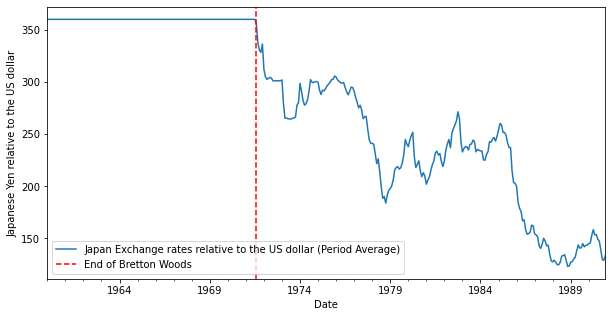

In [395]:
Country_data.set_index('Date', inplace=True)
Country_data['Japan Exchange rates relative to the US dollar (Period Average)'].plot(figsize=(10, 5))
plt.ylabel('Japanese Yen relative to the US dollar')
plt.axvline(x=dt.datetime(1971, 8, 1), linestyle='--', color='red', label='End of Bretton Woods')
plt.legend()

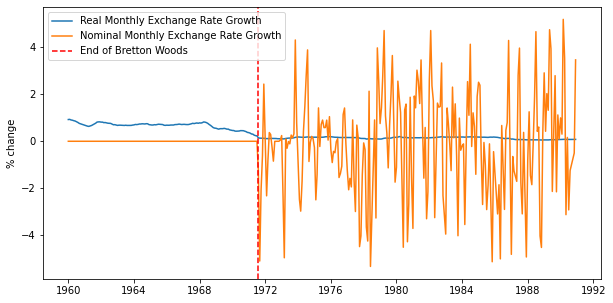

In [396]:
cols_to_plot = ['real_exchange_rate_growth', 'nominal_exchange_rate_growth']
plt.figure(figsize=(10, 5))
plt.plot(Japan_variables['real_exchange_rate_growth'], label='Real Monthly Exchange Rate Growth')
plt.plot(Japan_variables['nominal_exchange_rate_growth'], label='Nominal Monthly Exchange Rate Growth')
plt.ylabel('% change')
plt.axvline(x=dt.datetime(1971, 8, 1), linestyle='--', color='red', label='End of Bretton Woods')
plt.legend()


Text(1972-01-01, 400, 'Japan leaves\nBretton Woods')

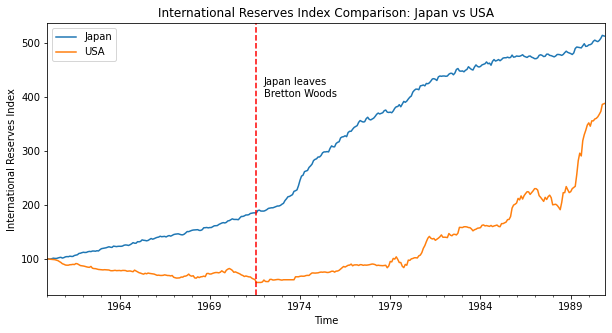

In [397]:
international_reserves_index_df = pd.concat([Japan_variables['japan_international_reserves_index'], USA_variables['usa_international_reserves_index']], axis=1)
international_reserves_index_df = international_reserves_index_df.rename(columns={'japan_international_reserves_index': 'Japan',  'usa_international_reserves_index': 'USA'})
international_reserves_index_df.plot(figsize=(10, 5))
plt.title('International Reserves Index Comparison: Japan vs USA')
plt.xlabel('Time')
plt.ylabel('International Reserves Index')
plt.axvline(x='1971-08-01', linestyle='--', color='red')
plt.annotate('Japan leaves\nBretton Woods', xy=('1971-08-01', 500), xytext=('1972-01-01', 400))


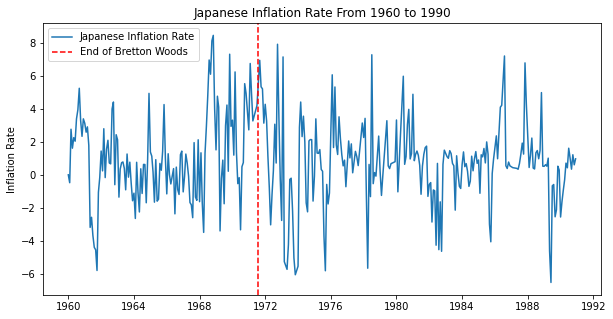

In [398]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Japan_variables['inflation_rate'], label='Japanese Inflation Rate')
plt.title('Japanese Inflation Rate From 1960 to 1990')
ax.set_ylabel('Inflation Rate')
ax.axvline(x=dt.datetime(1971, 8, 1), linestyle='--', color='red', label='End of Bretton Woods')
ax.legend()

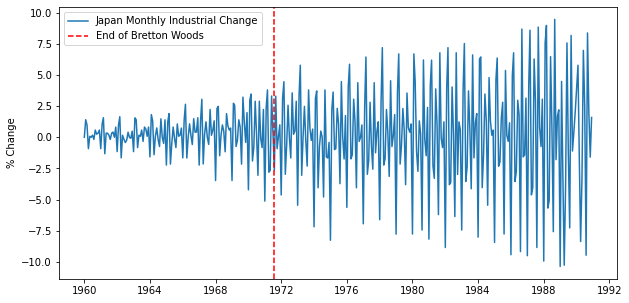

In [399]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Japan_variables['monthly_industrial_change'], label='Japan Monthly Industrial Change')
ax.set_ylabel('% Change')
ax.axvline(x=dt.datetime(1971, 8, 1), linestyle='--', color='red', label='End of Bretton Woods')
ax.legend()

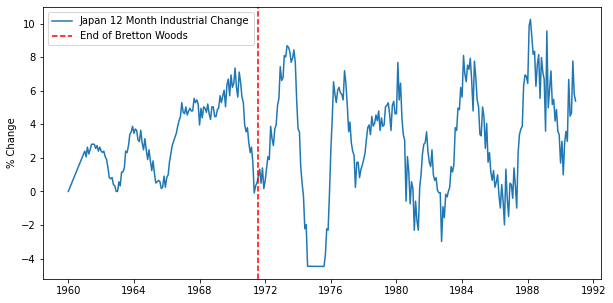

In [400]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Japan_variables['yearly_industrial_change'], label='Japan 12 Month Industrial Change')
ax.set_ylabel('% Change')
ax.axvline(x=dt.datetime(1971, 8, 1), linestyle='--', color='red', label='End of Bretton Woods')
ax.legend()

In [401]:
#calculating standard deviations:8er Japan left Bretton Woods, excluding the 10 months after is ' + str(std_after))

def std_before_and_after(df, col, var_name):
    # Calculate standard deviation before Japan left Bretton Woods
    std_before = df[col][:'1970-10-01'].std()
    #calculate standard deviation after Japan left Bretton Woods
    std_after = df[col]['1972-06-01':].std()
    # create a pandas DataFrame to store the results
    df_std = pd.DataFrame({
        'Variable': [var_name],
        'Std before': [std_before],
        'Std after': [std_after]
    })
    return df_std
    
#nominal exchange rate growth before and after
df_nominal_exchange_rate = std_before_and_after(Japan_variables, 'nominal_exchange_rate_growth', 'Nominal Exchange Rate Growth')

#real rate growth before and after
df_real_exchange_rate = std_before_and_after(Japan_variables, 'real_exchange_rate_growth', 'Real Exchange Rate Growth')

#inflation rate before and after
df_inflation_rate = std_before_and_after(Japan_variables, 'inflation_rate', 'Japanese Inflation Rate')

Japan_variables['diff_in_inflation_rate_Japan_v_USA'] = Japan_variables['inflation_rate'] - USA_variables['inflation_rate']
df_diff_in_inflation_rate = std_before_and_after(Japan_variables, 'diff_in_inflation_rate_Japan_v_USA', 'Difference between Japan and USA Inflation')

#annual industrial for japan before and after
df_yearly_industrial_change = std_before_and_after(Japan_variables, 'yearly_industrial_change', '12-monthly industrial production growth')

# concatenate all DataFrames into one
result = pd.concat([df_nominal_exchange_rate, df_real_exchange_rate, df_inflation_rate, df_diff_in_inflation_rate, df_yearly_industrial_change], ignore_index=True)

# display the concatenated DataFrame
display(result)

,Variable,Std before,Std after
0,Nominal Exchange Rate Growth,0.000000,2.235174
1,Real Exchange Rate Growth,0.110859,0.042986
2,Japanese Inflation Rate,2.601434,2.463024
3,Difference between Japan and USA Inflation,2.597255,2.500033
4,12-monthly industrial production growth,1.943678,3.463966
